In [4]:
#importing the neccessary dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# read into the pandas DataFrame
housing=pd.read_csv(r"C:\Users\joshua\Documents\housing.csv")

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


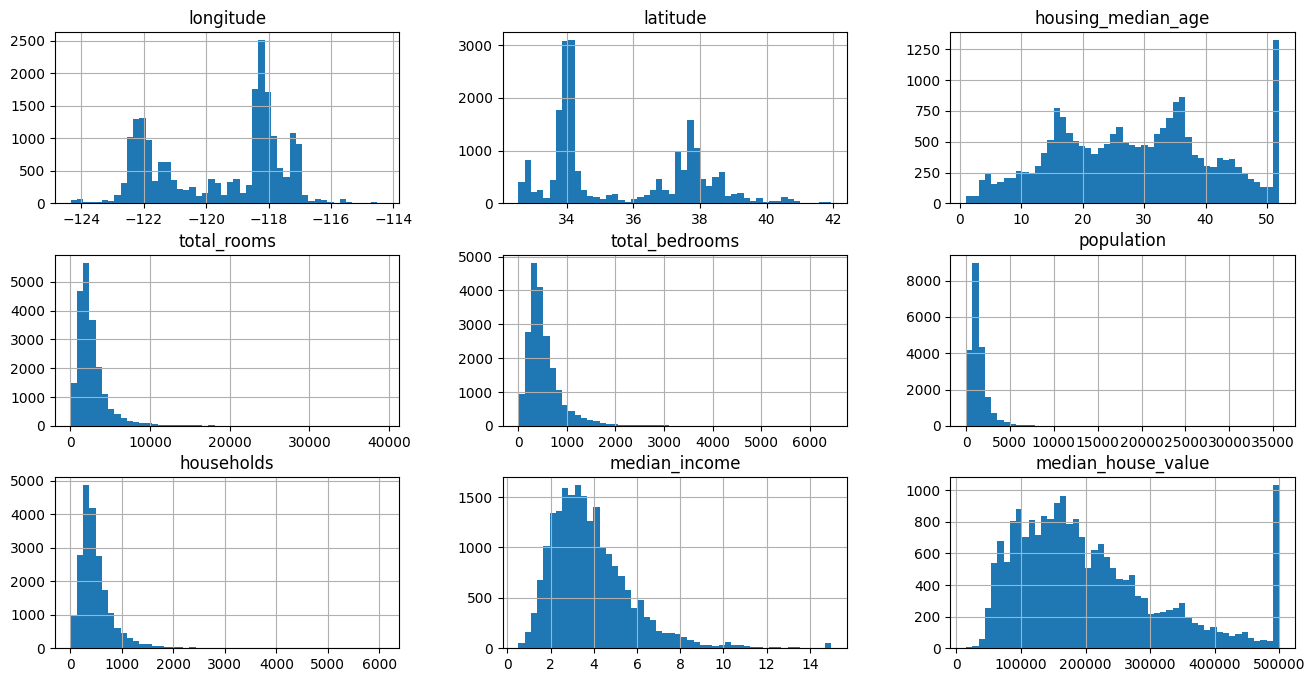

In [10]:
housing.hist(bins=50, figsize=(16, 8))
plt.show()

### Create a Test Set

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size=int(len(data) * test_ratio)
    test_indices=shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set =shuffle_and_split_data(housing, 0.2)
print(len(train_set))
print(len(test_set))

In [11]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids= data[id_column]
    in_test_set=ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id=housing.reset_index()
train_set, test_set =split_data_with_id_hash(housing_with_id, 0.2, "index")

housing_with_id["id"]=housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set =split_data_with_id_hash(housing_with_id, 0.2,"id")



In [12]:
from sklearn.model_selection import train_test_split

train_set, test_set=train_test_split(housing, test_size=0.2, random_state=42)

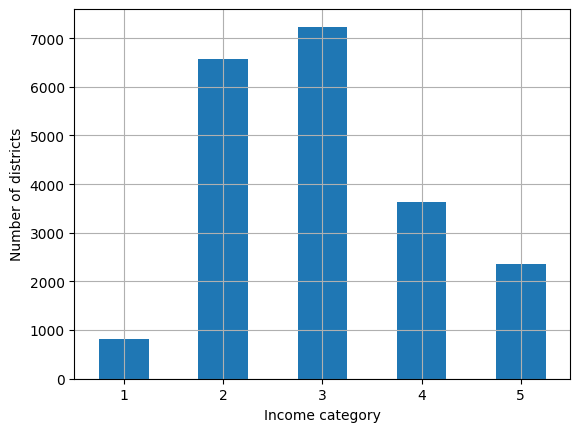

In [13]:
housing["income_cat"]=pd.cut(housing["median_income"],
                             bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                             labels=[1, 2, 3, 4, 5])

housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [14]:
# Stratified Sampling
from sklearn.model_selection import StratifiedShuffleSplit

splitter=StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits=[]
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n=housing.iloc[train_index]
    strat_test_set_n=housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

# using the first split
    strat_train_set, strat_test_set=strat_splits[0]

# Alternatively, using a shorter way
    strat_train_set, strat_test_set=train_test_split(
        housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)
    

In [15]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [16]:
# We won't use the income_cat column again. so we will drop it
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

### Explore and Visualize the Data to Gain Insights

In [17]:
# since you're going to experiment with various transformations of the full training set, we should make a copy of the original so we can revert to it afterwards:

housing = strat_train_set.copy()

### Visualizing Geographical Data

Because the dataset includes geographical information (latitude and longitude), it is a good idea to create a scatterplot of all the districts to visualize the data

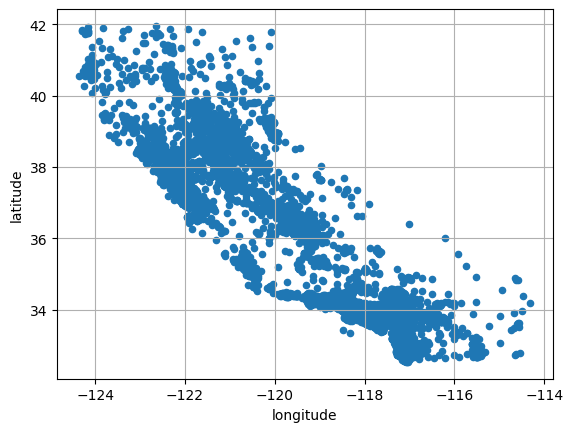

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True)
plt.show()

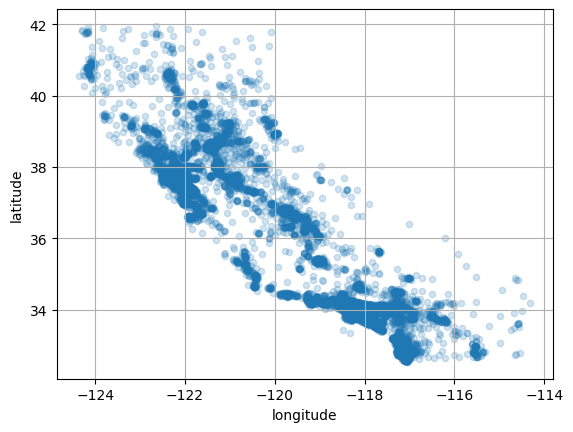

In [19]:
# setting the alpha option to 0.2

housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

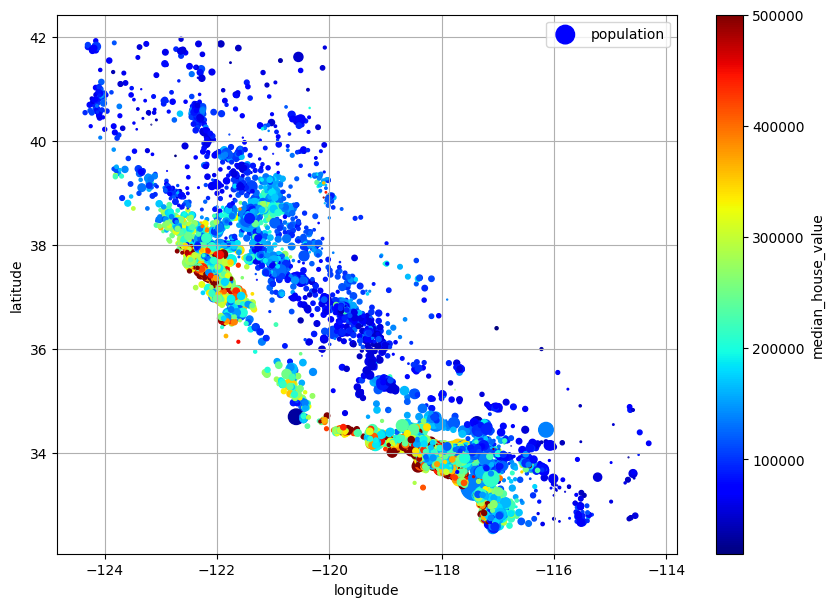

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label= "population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
plt.show()